# Audio Feature Extraction & Analysis

The aim of this project is to discover what combination of audio features gives the best performance with electronic versus organic source classification. Source recognition is treated as a binary classification problem, with a sound represented as either orginating from a live in-person source or an electronic source. Features extracted by [Essentia](http://essentia.upf.edu/) and [LibROSA](https://librosa.github.io/librosa/), tools for audio analysis and audio-based music information retrieval, were used.

**Next steps:** 
- examine the influence of various feature sets (e.g., low level, tonal, high-level, and their combination) on improving source recognition
- improve feature parsing methods for essentia + libROSA + other libraries
- develop a comprehensive feature set to characterize each audio file

In [1]:
%matplotlib inline  
import essentia
from essentia.standard import *
import essentia.standard as es
from os import listdir
from os.path import isfile, join, basename, splitext
import librosa
import librosa.display
import IPython
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("bright")

/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
valid_exts = ['.mp3', '.wav', '.flac']
dir_electronic = 'audio/Electronic/'
dir_organic = 'audio/Organic/'

# extract electronic file paths
electronic_files = [dir_electronic + x for x in 
   [f for f in listdir(dir_electronic) if (isfile(join(dir_electronic, f)) # get files only
   and bool([ele for ele in valid_exts if(ele in f)])) ]                   # get audio files only
  ]  

# extract organic file paths
organic_files = [dir_organic + x for x in 
   [f for f in listdir(dir_organic) if (isfile(join(dir_organic, f))       # get files only
   and bool([ele for ele in valid_exts if(ele in f)])) ]                   # get audio files only
  ] 

## Parsing in Essentia

In [103]:
def extract_essentia_features(audio, target = 0): # if no classification given, assume electronic
    features, feature_frames = es.MusicExtractor(
    lowlevelStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt'],
    rhythmStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt'],
    tonalStats=['mean', 'stdev', 'var', 'median', 'skew', 'kurt'])(audio)
    
    spectral_df = pd.DataFrame()#pd.DataFrame(columns=features.descriptorNames())
    feature_vals = []
    
    for feature in features.descriptorNames():
        if isinstance(features[feature], (float, int)):
            spectral_df[feature] = 0.
            feature_vals.append(features[feature])
        else: break
            
    spectral_df.loc[0] = feature_vals
    #spectral_df = spectral_df.fillna(0) # replace NaN with 0
    id_df = pd.DataFrame({'id' : [audio.split('/')[-1].split('.')[0]]})
    target_df = pd.DataFrame({'target' : [target]})
    
    final_df = pd.concat((id_df, spectral_df, target_df), axis = 1)
    return final_df

In [95]:
all_audio = []

print('\nReading ELECTRONIC directory ...')
for electronic_file in electronic_files:
    audio_features = extract_essentia_features(electronic_file, 0)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', electronic_file)

print('\nReading ORGANIC directory ...')
for organic_file in organic_files:
    audio_features = extract_essentia_features(organic_file, 1)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', organic_file)

print('\nPutting it altogether ...')
df_audio = pd.concat(all_audio)
# df_audio.set_index(audio['id'], inplace = True)
df_audio.to_csv('essentia_features.csv', index = True)
print('\nDONE.')


Reading ELECTRONIC directory ...
	Completed feature extraction for audio/Electronic/shopElecD.wav
	Completed feature extraction for audio/Electronic/musicbox.wav
	Completed feature extraction for audio/Electronic/stopElecD.wav
	Completed feature extraction for audio/Electronic/human_rights.mp3
	Completed feature extraction for audio/Electronic/closeElecD.wav
	Completed feature extraction for audio/Electronic/hello_google_ElecD.wav
	Completed feature extraction for audio/Electronic/openElecD.wav

Reading ORGANIC directory ...
	Completed feature extraction for audio/Organic/close_test.wav
	Completed feature extraction for audio/Organic/open_test.wav
	Completed feature extraction for audio/Organic/alexa_test.wav
	Completed feature extraction for audio/Organic/hello_google_test.wav
	Completed feature extraction for audio/Organic/stop_test.wav
	Completed feature extraction for audio/Organic/shop_test.wav

Putting it altogether ...

DONE.


## Parsing in LibROSA

In [3]:
def create_chroma_df(chroma):
    chroma_mean = np.mean(chroma, axis = 1)
    chroma_std = np.std(chroma, axis = 1)
    
    chroma_df = pd.DataFrame()
    for i in range(0,12):
        chroma_df['chroma ' + str(i) + ' mean'] = chroma_mean[i]
        chroma_df['chroma ' + str(i) + ' std'] = chroma_std[i]
    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis = 0)

    return chroma_df

In [4]:
def create_mfccs_df(mfccs):
    mfccs_mean = np.mean(mfccs, axis = 1)
    mfccs_std = np.std(mfccs, axis = 1)
   
    mfccs_df = pd.DataFrame()
    for i in range(0,13):
        mfccs_df['mfccs ' + str(i) + ' mean'] = mfccs_mean[i]
        mfccs_df['mfccs ' + str(i) + ' std'] = mfccs_std[i]
    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis = 0)
    
    return mfccs_df

In [5]:
def create_spectral_df(cent, contrast, rolloff, flatness):
    
    # spectral centroids values
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis = 1)[0]

    # spectral contrasts values
    contrast_mean = np.mean(contrast, axis = 1)
    contrast_std = np.std(contrast, axis = 1)
    
    # spectral rolloff points values
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis = 1)[0]
    
    # spectral flatness values
    flat_mean = np.mean(flatness)
    flat_std = np.std(flatness)
    flat_skew = scipy.stats.skew(flatness, axis = 1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent mean','cent std','cent skew',
               'flat mean', 'flat std', 'flat skew',
               'rolloff mean', 'rolloff std', 'rolloff skew']
    for i in range(0,7):
        collist.append('contrast ' + str(i) + ' mean')
        collist.append('contrast ' + str(i) + ' std')
    
    for c in collist:
        spectral_df[c] = 0
    data = np.concatenate((
        [cent_mean, cent_std, cent_skew], 
        [flat_mean, flat_std, flat_skew],
        [rolloff_mean, rolloff_std, rolloff_skew], 
        contrast_mean, contrast_std),
        axis = 0)
    spectral_df.loc[0] = data
    
    return spectral_df

In [6]:
def create_zrate_df(zrate):
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis = 1)[0]

    zrate_df = pd.DataFrame()
    zrate_df['zrate mean'] = 0
    zrate_df['zrate std'] = 0
    zrate_df['zrate skew'] = 0
    zrate_df.loc[0]=[zrate_mean, zrate_std, zrate_skew]
    
    return zrate_df

In [7]:
def create_beat_df(tempo):
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo
    return beat_df

In [8]:
def extract_features(audio, target = 0): # if no classification given, assume electronic
    y, sr = librosa.load(audio)
    
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    beat_time_diff = np.ediff1d(beat_times)
    beat_nums = np.arange(1, np.size(beat_times))
    
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    flatness = librosa.feature.spectral_flatness(y=y)
    
    contrast = librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
    
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    
    chroma_df = create_chroma_df(chroma)
    
    mfccs_df = create_mfccs_df(mfccs)
    
    spectral_df = create_spectral_df(cent, contrast, rolloff, flatness)
    
    zrate_df = create_zrate_df(zrate)
    
    beat_df = create_beat_df(tempo)
    
    id_df = pd.DataFrame({'id' : [audio.split('/')[-1].split('.')[0]]})
    
    target_df = pd.DataFrame({'target' : [target]})
    
    final_df = pd.concat((id_df, chroma_df, mfccs_df, spectral_df, zrate_df, beat_df, target_df), axis = 1)
    
    return final_df

In [12]:
all_audio = []

print('\nReading ELECTRONIC directory ...')
for electronic_file in electronic_files:
    audio_features = extract_features(electronic_file, 0)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', electronic_file)

print('\nReading ORGANIC directory ...')
for organic_file in organic_files:
    audio_features = extract_features(organic_file, 1)
    all_audio.append(audio_features)
    print('\tCompleted feature extraction for', organic_file)

print('\nPutting it altogether ...')
df_audio = pd.concat(all_audio)
# df_audio.set_index(audio['id'], inplace = True)
df_audio.to_csv('librosa_features.csv', index = True)
print('\nDONE.')


Reading ELECTRONIC directory ...
	Completed feature extraction for audio/Electronic/shopElecD.wav
	Completed feature extraction for audio/Electronic/musicbox.wav
	Completed feature extraction for audio/Electronic/stopElecD.wav


/usr/local/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


	Completed feature extraction for audio/Electronic/human_rights.mp3
	Completed feature extraction for audio/Electronic/closeElecD.wav
	Completed feature extraction for audio/Electronic/hello_google_ElecD.wav
	Completed feature extraction for audio/Electronic/openElecD.wav

Reading ORGANIC directory ...
	Completed feature extraction for audio/Organic/close_test.wav
	Completed feature extraction for audio/Organic/open_test.wav
	Completed feature extraction for audio/Organic/alexa_test.wav
	Completed feature extraction for audio/Organic/hello_google_test.wav
	Completed feature extraction for audio/Organic/stop_test.wav
	Completed feature extraction for audio/Organic/shop_test.wav

Putting it altogether ...

DONE.


## Understanding the Dataset

In [88]:
print(df_audio.target)

0    0
0    0
0    0
0    0
0    0
0    0
0    0
0    1
0    1
0    1
0    1
0    1
0    1
Name: target, dtype: int64


In [96]:
print(df_audio.shape)      # output: (n_samples, n_features)
print(df_audio.keys())     # available data attributes
print(df_audio[0:3])       # show example data rows

(13, 304)
Index(['id', 'lowlevel.average_loudness', 'lowlevel.barkbands_crest.kurt',
       'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.median',
       'lowlevel.barkbands_crest.skew', 'lowlevel.barkbands_crest.stdev',
       'lowlevel.barkbands_crest.var', 'lowlevel.barkbands_flatness_db.kurt',
       'lowlevel.barkbands_flatness_db.mean',
       ...
       'tonal.tuning_equal_tempered_deviation', 'tonal.tuning_frequency',
       'tonal.tuning_nontempered_energy_ratio', 'target',
       'rhythm.beats_loudness.dmean', 'rhythm.beats_loudness.dmean2',
       'rhythm.beats_loudness.dvar', 'rhythm.beats_loudness.dvar2',
       'rhythm.beats_loudness.max', 'rhythm.beats_loudness.min'],
      dtype='object', length=304)
          id  lowlevel.average_loudness  lowlevel.barkbands_crest.kurt  \
0  shopElecD                   0.990684                      -0.109786   
0   musicbox                   0.961364                       0.286037   
0  stopElecD                   0.990684

## Data Visualization

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
df_audio.describe()

,index,lowlevel.average_loudness,lowlevel.barkbands_crest.kurt,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.skew,lowlevel.barkbands_crest.stdev,lowlevel.barkbands_crest.var,lowlevel.barkbands_flatness_db.kurt,lowlevel.barkbands_flatness_db.mean,...,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio,target,rhythm.beats_loudness.dmean,rhythm.beats_loudness.dmean2,rhythm.beats_loudness.dvar,rhythm.beats_loudness.dvar2,rhythm.beats_loudness.max,rhythm.beats_loudness.min
count,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,1.0,1.0,1.0,1.0,1.0,1.0
mean,0.0,0.986051,-0.259801,16.727361,17.707899,-0.439003,4.527413,21.501646,-0.123064,0.331834,...,0.242010,443.164642,0.884175,0.461538,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.011315,0.669940,2.441598,3.226654,0.474809,1.043004,9.875612,0.933773,0.038511,...,0.049233,7.903091,0.053425,0.518875,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.959771,-1.333978,10.944942,10.610213,-0.910028,2.801495,7.848374,-1.226775,0.289956,...,0.100651,431.692352,0.735131,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.990684,-0.752981,16.741146,17.349791,-0.728818,3.875585,15.020157,-0.785126,0.303028,...,0.234501,436.456207,0.867258,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.990684,-0.109786,17.399883,18.415758,-0.564405,4.356682,18.980680,-0.436654,0.322877,...,0.249827,442.804626,0.899676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.990684,0.286037,17.894707,19.934769,-0.452681,5.189511,26.931025,0.135676,0.352336,...,0.271581,447.432556,0.908252,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.990684,0.703735,19.338318,21.052734,0.641741,6.275601,39.383175,1.885017,0.425822,...,0.299523,455.779724,0.963951,1.000000,0.0,0.0,0.0,0.0,0.0,0.0


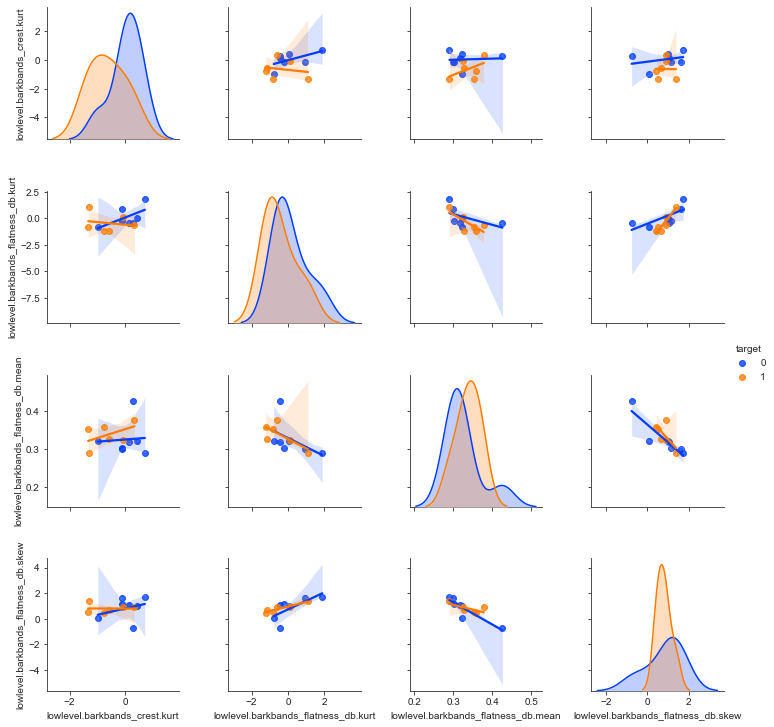

In [141]:
# librosa plot example
'''sns.pairplot(
    df_audio, 
    hue="target", 
    vars=['flat mean', 'flat std', 'rolloff mean', 'rolloff std', 'zrate mean', 'zrate std'],
    kind="reg"
)'''

# essentia plot example
sns.pairplot(
    df_audio, 
    hue="target", 
    vars=['lowlevel.barkbands_crest.kurt', 'lowlevel.barkbands_flatness_db.kurt', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.skew'],
    kind="reg"
)

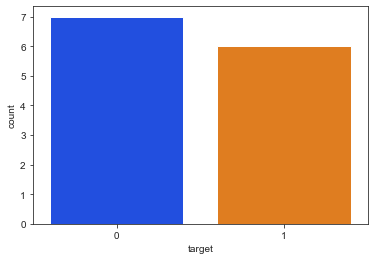

In [142]:
sns.countplot(df_audio['target'], label="Count")

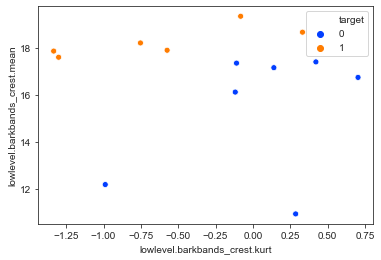

In [144]:
# librosa plot example
#sns.scatterplot(x = 'rolloff mean', y = 'cent mean', hue = 'target', data = df_audio)

# essentia plot example
sns.scatterplot(x = 'lowlevel.barkbands_crest.kurt', y = 'lowlevel.barkbands_crest.mean', hue = 'target', data = df_audio)

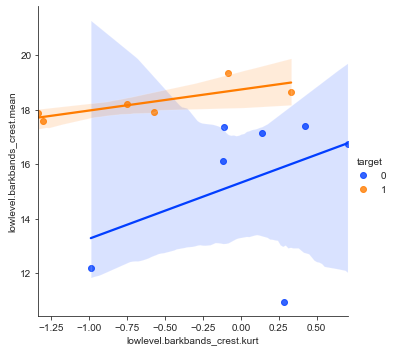

In [145]:
# librosa plot example
# sns.lmplot('rolloff mean', 'cent mean', hue ='target', data = df_audio, fit_reg=True)

# essentia plot example
sns.lmplot('lowlevel.barkbands_crest.kurt', 'lowlevel.barkbands_crest.mean', hue ='target', data = df_audio, fit_reg=True)

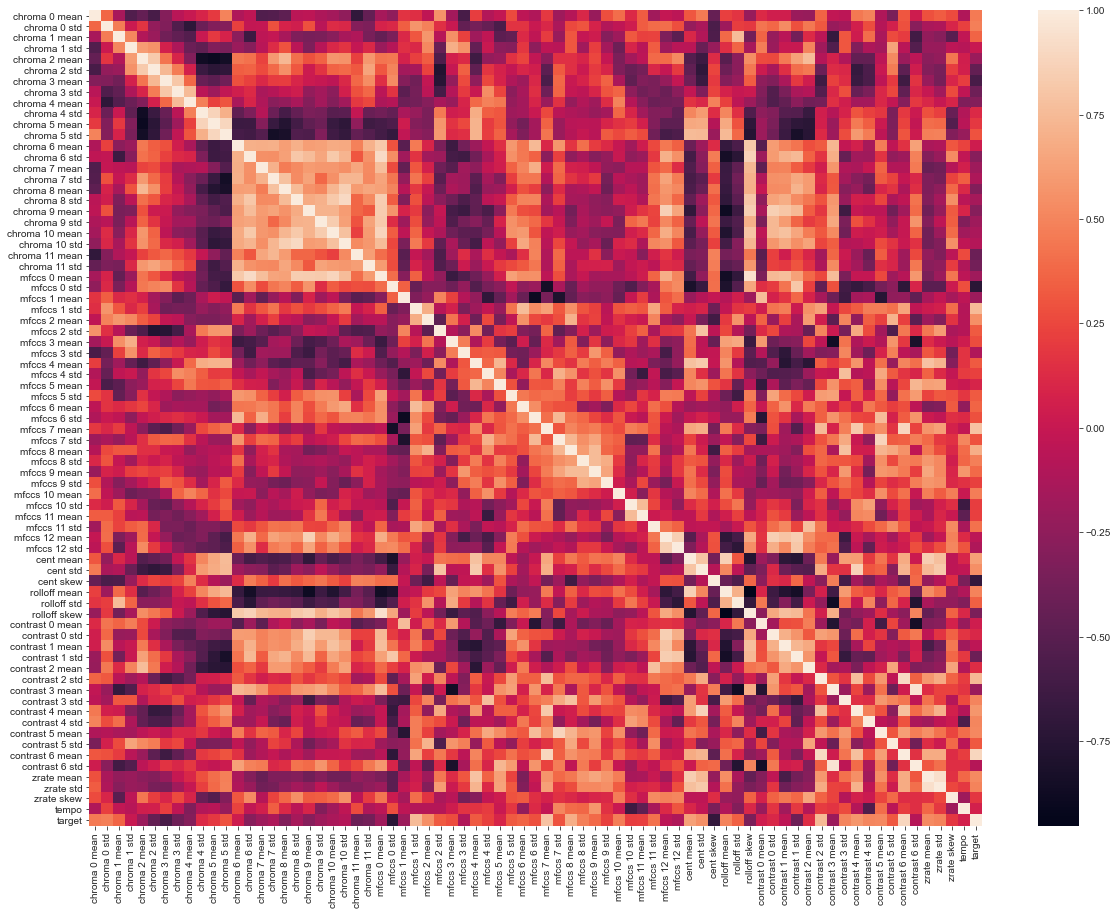

In [20]:
plt.figure(figsize=(20,15)) 
sns.heatmap(df_audio.corr(), annot=False) 

### Building a Classifier
Here we implement a ML algorithm and evaluate its performance using different training and testing datasets.

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.80      0.89         5

    accuracy                           0.86         7
   macro avg       0.83      0.90      0.84         7
weighted avg       0.90      0.86      0.86         7



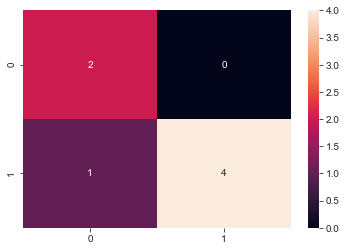

In [108]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

df_audio.fillna(df_audio.mean(), inplace=True) # replace NaN/infinite values

X_train, X_test, y_train, y_test = train_test_split(
    df_audio.drop(['target', 'id'], axis=1),         # feature values per sample
    df_audio['target'],       # target labels per sample
    test_size=0.5,            # 50% test/ 50% training; proportion of the dataset to include in the test split
    random_state=109          # controls the shuffling applied to the data before applying split
)

classifier = svm.SVC(kernel='linear', probability=True) # create a SVM classifier with a linear kernel
classifier.fit(X_train, y_train)      # train model using the training sets
y_pred = classifier.predict(X_test)   # predict the response for test dataset

confusion = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True)

print(metrics.classification_report(y_test, y_pred))

### Evaluating Performance using K-fold Cross Validation
Cross validation can be used to estimate the performance of a ML algorithm with less variance than a single train-test set split. The K-fold method splits the dataset into k-parts (aka folds). The algorithm is trained on k-1 folds with one fold saved for testing. 

This splitting process is repeated so that each fold of the dataset is given a chance to be the test set. The cross validation returns k performance scores that can be summarized using a mean and a standard deviation. Because the algorithm is trained and evaluated multiple times on different datasets, this result is a more reliable estimate of the performance of an algorithm.

In [146]:
from sklearn import model_selection, linear_model
from sklearn.linear_model import LogisticRegression

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

Distribution: [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
Accuracy (mean): 60.000% 
 Accuracy (std): 48.990%


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### Evaluating Performance with Leave One Out Cross Validation
Configuring cross validation so that the size of the fold is 1 (k = number of samples in the dataset), makes this a leave-one-out cross validation. The result is several performance measures that can be summarized to give a reasonable estimate of the accuracy of your model on unseen data. However, it's more computationally expensive than k-fold cross validation. 

In [147]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

num_folds = 10
loocv = model_selection.LeaveOneOut()
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, Y, cv=loocv)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

Distribution: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
Accuracy (mean): 46.154% 
 Accuracy (std): 49.852%


### Evaluating Performance using Repeated Random Test-Train Splits
Another k-fold cross validation variation involves creating a random split of the data (such as that made in the train/test split above, but the process is repeated on splitting and evaluating the algorithm multiple times (like cross validation). 

This method has the speed of using a simple train/test split and a reduction in standard deviation in estimated performance of a k-fold cross validation. However, the down side of these repetitions is that they may include much of the same data in the train/test split from run to run, therefore introducing redundancy into the evaluation.

The example below splits the data into a 75%/25% train/test split and repeats the process 10 times.

In [148]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

test_size = 0.25
seed = 7
kfold = model_selection.ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, Y, cv=kfold)
print("Distribution:", results)
print("Accuracy (mean): %.3f%% \n Accuracy (std): %.3f%%" % (results.mean()*100.0, results.std()*100.0))

Distribution: [0.5  0.25 0.25 0.25 0.5  0.25 0.5  0.   0.5  0.75]
Accuracy (mean): 37.500% 
 Accuracy (std): 20.156%


### ROC Curves
Another popular method for evaluating classifer output quality. ROC (Receiver Operating Characteristic) curves typically feature true positive rates on the Y and false positive rates on the X axis. This means that the top left corner of the plot is the "ideal" (a false positive rate = 0 and true positive rate = 1). Although this is not very realistic, a larger area under the curve (AUC) is preferred. 

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


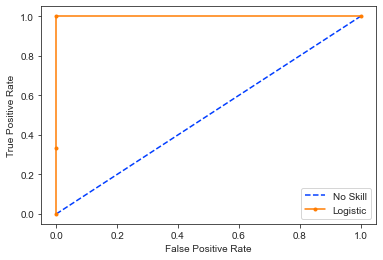

In [149]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
lr_probs = classifier.predict_proba(X_test)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Precision-Recall Curve
Where the ROC curves summarize the trade-off between the true positive and false positive rates for a classifier using different probability thresholds, the precision-recall curve summarizes the trade-off between the true positive rate and the positive predictive value for a classifier using different probability thresholds. 

Logistic: f1=0.000 auc=1.000


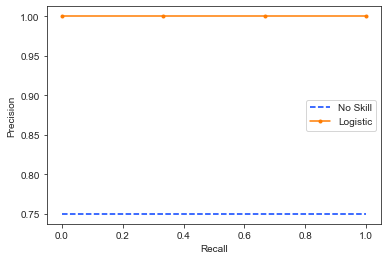

In [150]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = classifier.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
y_hat = classifier.predict(X_test)

# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

# calculate scores
lr_f1, lr_auc = f1_score(y_test, y_hat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### Deciding which performance evaluation techniques to use when
- **k-fold** cross validation is considered the gold-standard for evaluating the performance of a ML algorithm on unseen data with *k* set to 3, 5, or 10. 
- **train/test** splitting is good for speed when the ML algorithm is slow. This technique also produces performance estimates with lower bias when using large datasets.
- **leave-one-out** cross validation and **repeated random splits** are useful intermediates when trying to balance variance in estimated performance results, model training size, and dataset size.
- When in doubt, use a **10-fold cross validation**
- **ROC** curves are appropriate when the observations are balanced between each class whereas **precision-recall** curves are more appropriate for more imbalanced datasets. 

## Other ML

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

In [110]:
h = 0.02 # step size in the mesh
names = [
    'Nearest Neighbors', 
    'Linear SVM', 
    'RBF SVM',
    'Gaussian Process', 
    'Decision Tree', 
    'Random Forest', 
    'Neural Net', 
    'AdaBoost', 
    'Naive Bayes', 
    'QDA'
]
classifiers = [
    KNeighborsClassifier(3),       # number of neighbors = 3
    SVC(kernel='linear', C=0.025), # linear kernel with regularization/misclassification error = 0.025
    SVC(gamma=2, C=0.025),             # looser SVM with higher regularization
    GaussianProcessClassifier(1.0 * RBF(1.0)), # RBF kernel
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), # estimators = # of trees in the forest, max_features = # of features to consider when looking for best split
    MLPClassifier(alpha=0.025, max_iter=1000), # multilayer perceptron with L2 penalty/regularization = 1, max_iter = limit as solver iterates until convergence
    AdaBoostClassifier(), 
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

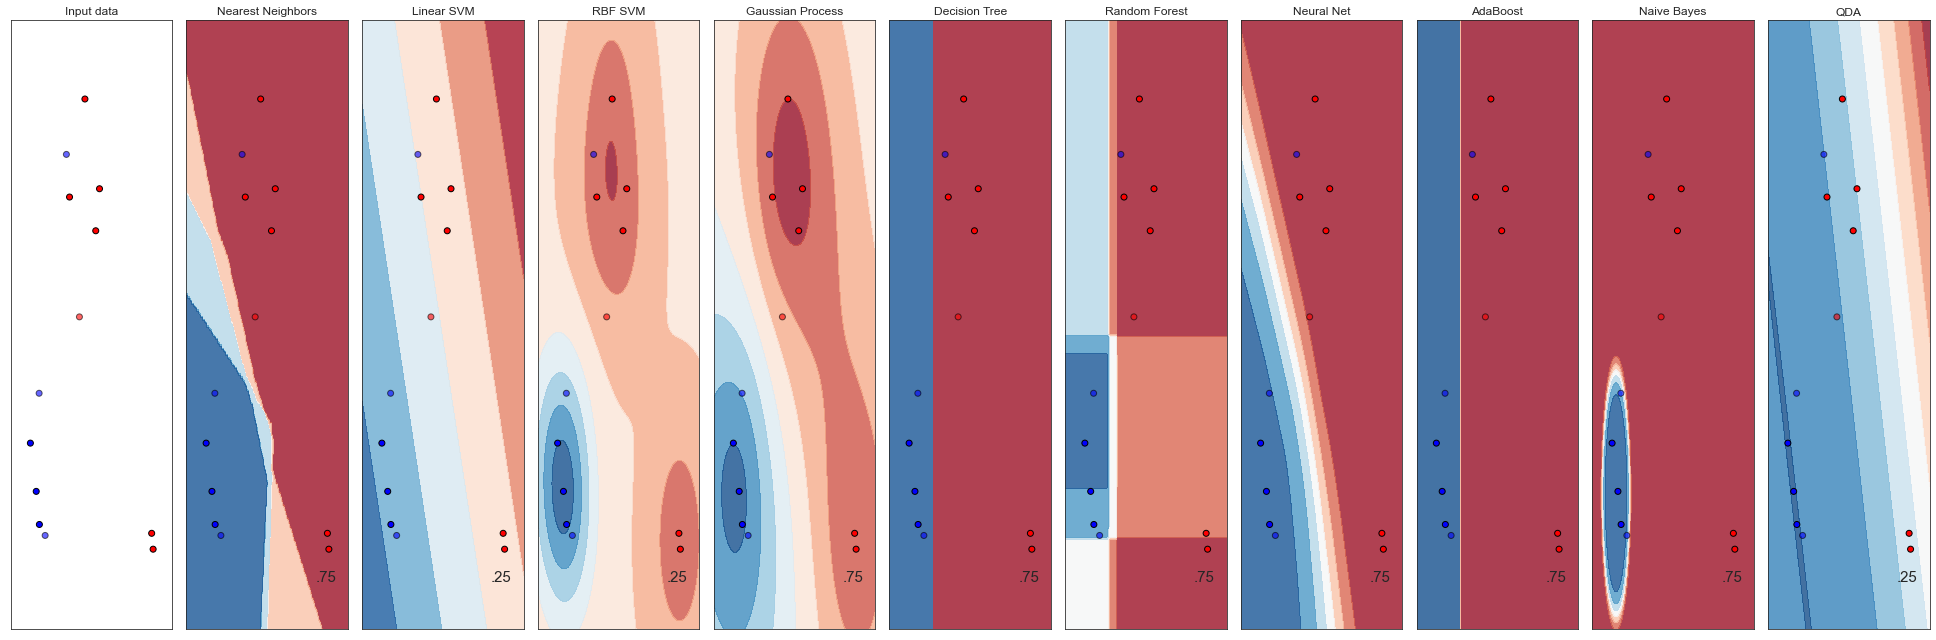

In [111]:
pca = PCA(n_components=2,svd_solver='full') # use n_components ='mle' when n_samples > n_features

X = df_audio.drop(['target', 'id'], axis = 1).values
X = pca.fit_transform(X)
y = df_audio['target']

rng = np.random.RandomState(2)
datasets = [df_audio]

figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

100


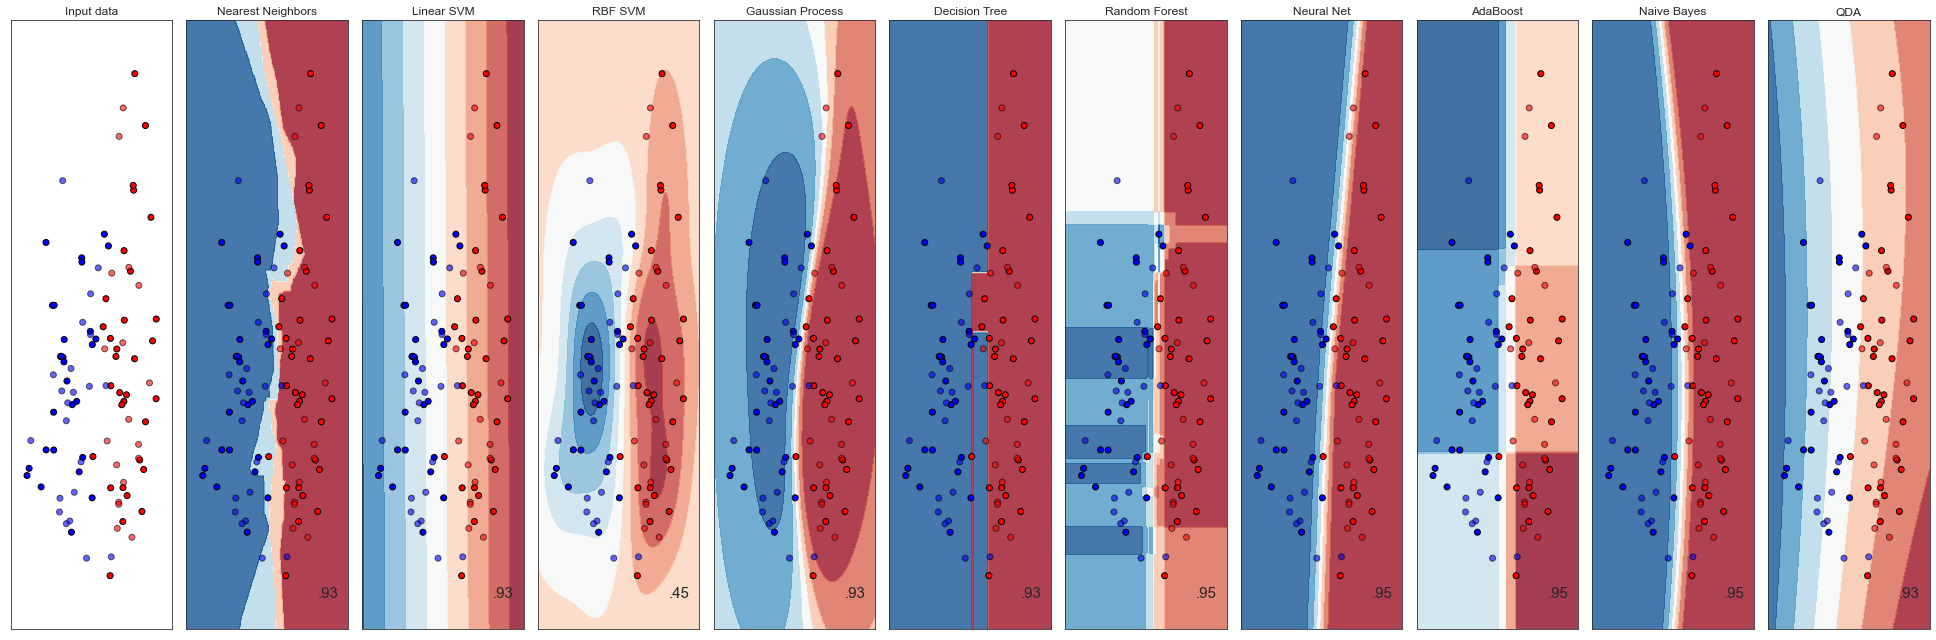

In [112]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
print(len(y))
#X = df_audio.drop(['target', 'id'], axis = 1).values
#X = pca.fit_transform(X)
#y = df_audio['target']
datasets = [df_audio]

figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    #X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df_audio.drop(['target', 'id'], axis = 1).values
Y = df_audio['target']

X = StandardScaler().fit_transform(X)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

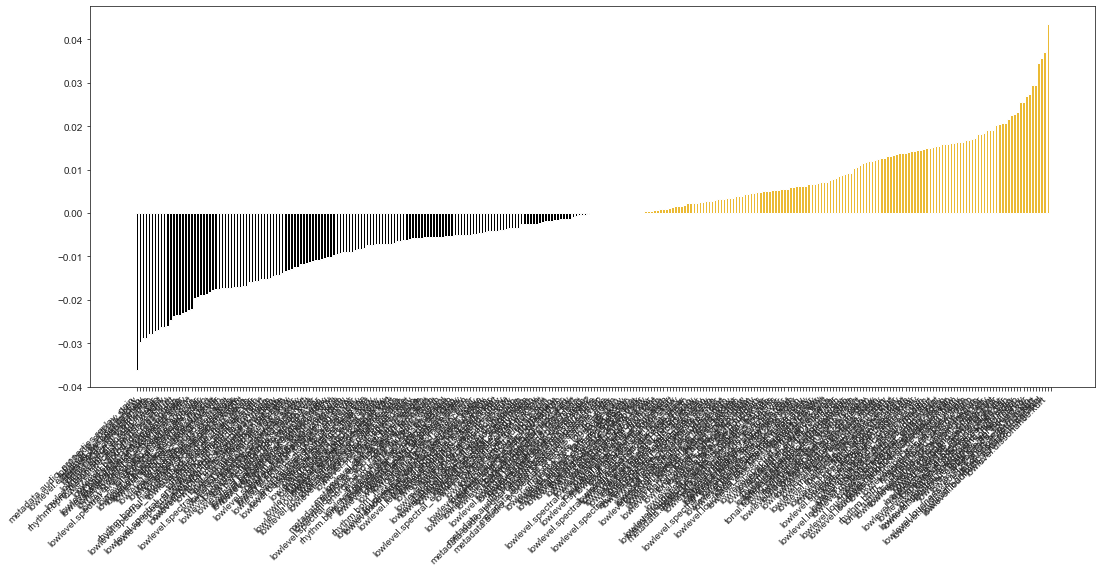

In [121]:
from sklearn import svm
import matplotlib.pyplot as plt

def feature_plot(classifier, feature_names, top_features=4):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['#000000' if c < 0 else '#ebba34' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

trainedsvm = svm.LinearSVC().fit(X, Y)
feature_plot(
    trainedsvm,
    df_audio.drop(['target', 'id'], axis = 1).columns.values, 
    int(len(df_audio.drop(['target', 'id'], axis = 1).columns.values) / 2)
)

In [122]:
# Preprocessing :
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Logistic Regression

In [123]:
trainedmodel = LogisticRegression().fit(X_Train,Y_Train)
predictions = trainedmodel.predict(X_Test)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### Random Forest

In [124]:
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### SVMs

In [110]:
trainedsvm = svm.LinearSVC().fit(X_Train, Y_Train)
predictionsvm = trainedsvm.predict(X_Test)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### Decision Tree

In [111]:
trainedtree = tree.DecisionTreeClassifier().fit(X_Train, Y_Train)
predictionstree = trainedtree.predict(X_Test)
print(confusion_matrix(Y_Test,predictionstree))
print(classification_report(Y_Test,predictionstree))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



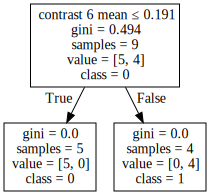

In [112]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = export_graphviz(
    trainedtree,out_file = None,
    feature_names = df_audio.drop(['target', 'id'], axis = 1).columns,
    class_names = ['0', '1'], 
    max_depth = 2,
    special_characters = True
)
graph = graphviz.Source(data)
graph

### Linear Discriminant Analysis

In [113]:
trainedlda = LinearDiscriminantAnalysis().fit(X_Train, Y_Train)
predictionlda = trainedlda.predict(X_Test)
print(confusion_matrix(Y_Test,predictionlda))
print(classification_report(Y_Test,predictionlda))

[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



### Naive Bayes

In [114]:
trainednb = GaussianNB().fit(X_Train, Y_Train)
predictionnb = trainednb.predict(X_Test)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

[[2 0]
 [1 1]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



### XGBoost

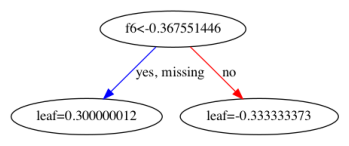

<Figure size 3600x3600 with 0 Axes>

In [115]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
model = XGBClassifier()

# Train
model.fit(X_Train, Y_Train)

plot_tree(model)
plt.figure(figsize = (50,50))
plt.show()

In [115]:
from itertools import product
import itertools

predictions = model.predict(X_Test)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

# Thanks to: https://www.kaggle.com/tejainece/data-visualization-and-machine-learning-algorithms
def plot_confusion_matrix(cm, classes=["0", "1"], title="",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot = confusion_matrix(Y_Test,predictions)

plt.figure()
plot_confusion_matrix(cm_plot, title = 'XGBClassifier')

NameError: name 'model' is not defined

## Feature Engineering

In [125]:
#import sys
names = [
    'Nearest Neighbors', 
    'Linear SVM', 
    'RBF SVM',
    'Gaussian Process', 
    'Decision Tree', 
    'Random Forest', 
    'Neural Net', 
    'AdaBoost', 
    'Naive Bayes', 
    'QDA'
]
classifiers = [
    KNeighborsClassifier(3),       # number of neighbors = 3
    SVC(kernel='linear', C=0.025), # linear kernel with regularization/misclassification error = 0.025
    SVC(gamma=2, C=0.025),             # looser SVM with higher regularization
    GaussianProcessClassifier(1.0 * RBF(1.0)), # RBF kernel
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), # estimators = # of trees in the forest, max_features = # of features to consider when looking for best split
    MLPClassifier(alpha=0.025, max_iter=1000), # multilayer perceptron with L2 penalty/regularization = 1, max_iter = limit as solver iterates until convergence
    AdaBoostClassifier(), 
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

X = df_audio.drop(['target', 'id'], axis = 1).values
y = df_audio['target']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)

#sys.stdout = open("performance-1.txt", "w")

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name)
    predictionnb = clf.predict(X_test)
    print(confusion_matrix(Y_Test,predictionnb))
    print(classification_report(Y_Test,predictionnb))

#sys.stdout.close()

Nearest Neighbors
[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

Linear SVM
[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

RBF SVM
[[2 0]
 [2 0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Net
[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

AdaBoost
[[1 1]
 [1 1]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

Naive Bayes
[[1 1]
 [2 0]]
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20        

/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [127]:
#pca = PCA(n_components=2,svd_solver='full')
#X_pca = pca.fit_transform(X)
#print(pca.explained_variance_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(
    #X, #X_pca, 
    #y, 
    df_audio.drop(['target', 'id'], axis=1),         # feature values per sample
    df_audio['target'],       # target labels per sample
    test_size = 0.30, 
    random_state = 101)

# pca = PCA(n_components=2,svd_solver='full')
# X_reduced = pca.fit_transform(X_Train)
# X_reduced = TSNE(n_components=2).fit_transform(X_Train, Y_Train)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_reduced,Y_Train)
trainedmodel = LogisticRegression().fit(X_reduced,Y_Train)

# pca = PCA(n_components=2,svd_solver='full')
# X_test_reduced = pca.fit_transform(X_Test)
# X_test_reduced = TSNE(n_components=2).fit_transform(X_Test, Y_Test)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

print('Random Forest')
predictionforest = trainedforest.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

print('Logistic Regression')
predictions =trainedmodel.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictions))
print(classification_report(Y_Test,predictions))

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Naive Bayes
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

SVM
[[0 2]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4

Random Forest
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
reduced_data = X_reduced

trainednb = GaussianNB().fit(reduced_data, Y_Train)
trainedsvm = svm.LinearSVC().fit(reduced_data, Y_Train)
trainedforest = RandomForestClassifier(n_estimators=700).fit(reduced_data,Y_Train)
trainedmodel = LogisticRegression().fit(reduced_data,Y_Train)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [trainednb, trainedsvm, trainedforest, trainedmodel],
                        ['Naive Bayes Classifier', 'SVM',
                         'Random Forest', 'Logistic Regression']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_Train,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TypeError: '(slice(None, None, None), 0)' is an invalid key

### Linear Discriminant Analysis

In [129]:
# Load libraries
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA that will reduce the data down to 1 feature
lda = LinearDiscriminantAnalysis(n_components=1)

# run an LDA and use it to transform the features
X_lda = lda.fit(X, Y).transform(X)

# Print the number of features
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_lda.shape[1])

## View the ratio of explained variance
print(lda.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_lda, Y, test_size = 0.30, random_state = 101)

trainednb = GaussianNB().fit(X_reduced, Y_Train)
trainedsvm = svm.LinearSVC().fit(X_reduced, Y_Train)

print('Naive Bayes')
predictionnb = trainednb.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionnb))
print(classification_report(Y_Test,predictionnb))

print('SVM')
predictionsvm = trainedsvm.predict(X_test_reduced)
print(confusion_matrix(Y_Test,predictionsvm))
print(classification_report(Y_Test,predictionsvm))

Original number of features: 303
Reduced number of features: 1
[1.]
Naive Bayes
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

SVM
[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



### t-SNE

In [130]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 12 nearest neighbors...
[t-SNE] Indexed 13 samples in 0.000s...
[t-SNE] Computed neighbors for 13 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 13 / 13
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.544926
[t-SNE] KL divergence after 300 iterations: 0.333579
t-SNE done! Time elapsed: 0.689460039138794 seconds


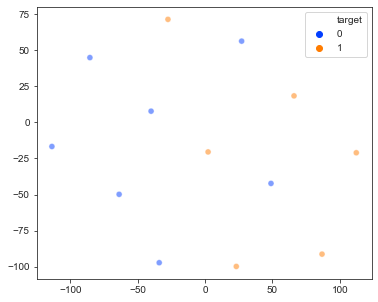

In [131]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x = tsne_results[:,0], y=tsne_results[:,1],
    hue = Y,
    palette = sns.color_palette("bright", 2),
    data = df_audio,
    legend = "full",
    alpha = 0.5
)

## Clustering

In [42]:
pca = PCA(n_components=2,svd_solver='full')
X_pca = pca.fit_transform(X)

print('PCA Explained Variance: ', pca.explained_variance_)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_lda.shape[1])
print('PCA Explained Variance Ratio: ', pca.explained_variance_ratio_)

X_reduced, X_test_reduced, Y_Train, Y_Test = train_test_split(X_pca, Y, test_size = 0.30, random_state = 101)

PCA Explained Variance:  [22.79265882 13.50943425]
Original number of features: 74
Reduced number of features: 1
PCA Explained Variance Ratio:  [0.28431591 0.16851685]


### K-Means

In [43]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced)
kpredictions = kmeans.predict(X_test_reduced)
print(confusion_matrix(Y_Test,kpredictions))
print(classification_report(Y_Test,kpredictions))

[[2 0]
 [2 0]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.00      0.00      0.00         2

    accuracy                           0.50         4
   macro avg       0.25      0.50      0.33         4
weighted avg       0.25      0.50      0.33         4



/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


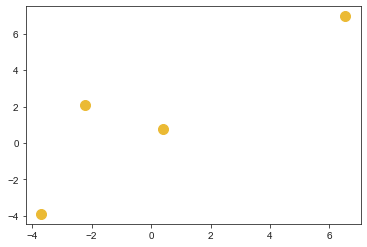

In [44]:
plt.scatter(X_test_reduced[kpredictions ==0,0], X_test_reduced[kpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[kpredictions ==1,0], X_test_reduced[kpredictions == 1,1], s=100, c='#000000')

### Hierarchical Clustering

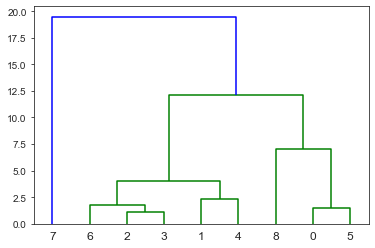

In [45]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(X_reduced, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
hierarchicalpredictions = hc.fit_predict(X_test_reduced)

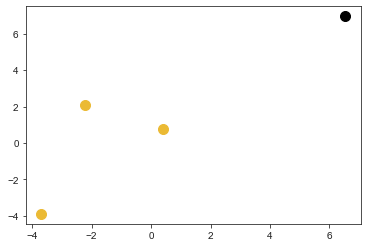

In [46]:
plt.scatter(X_test_reduced[hierarchicalpredictions ==0,0], X_test_reduced[hierarchicalpredictions == 0,1], s=100, c='#ebba34')
plt.scatter(X_test_reduced[hierarchicalpredictions ==1,0], X_test_reduced[hierarchicalpredictions == 1,1], s=100, c='#000000')

### Deep Learning

In [47]:
from keras.utils.np_utils import to_categorical
Y_Train = to_categorical(Y_Train)

Using TensorFlow backend.


In [48]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization, Activation

#Y_Test = to_categorical(Y_Test)

input_dim = X_Train.shape[1]
nb_classes = Y_Train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(512, input_dim=input_dim))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

print("Training...")
model.fit(X_Train, Y_Train, nb_epoch=50, batch_size=16, validation_split=0.1, verbose=80)

preds = model.predict_classes(X_Test, verbose=0)

Training...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8 samples, validate on 1 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [49]:
print(confusion_matrix(Y_Test,preds))
print(classification_report(Y_Test,preds))

[[2 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# Feature Selection

In [132]:
import pandas as pd
import numpy as np

X = df_audio.drop(['target', 'id'], axis=1)
y = df_audio['target']
df_audio.head()

,index,id,lowlevel.average_loudness,lowlevel.barkbands_crest.kurt,lowlevel.barkbands_crest.mean,lowlevel.barkbands_crest.median,lowlevel.barkbands_crest.skew,lowlevel.barkbands_crest.stdev,lowlevel.barkbands_crest.var,lowlevel.barkbands_flatness_db.kurt,...,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio,target,rhythm.beats_loudness.dmean,rhythm.beats_loudness.dmean2,rhythm.beats_loudness.dvar,rhythm.beats_loudness.dvar2,rhythm.beats_loudness.max,rhythm.beats_loudness.min
0,0,shopElecD,0.990684,-0.109786,17.348042,18.415758,-0.820982,3.875585,15.020157,-0.206149,...,0.276194,435.197479,0.908252,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,musicbox,0.961364,0.286037,10.944942,10.610213,0.641741,2.801495,7.848374,-0.454705,...,0.100651,444.085327,0.735131,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,stopElecD,0.990684,-0.118155,16.118462,16.380527,-0.025704,3.788017,14.349069,0.935253,...,0.240714,437.213165,0.867258,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,human_rights,0.959771,-0.988670,12.192229,11.632984,0.362096,6.204832,38.499939,-0.785126,...,0.274882,447.432556,0.899741,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,closeElecD,0.990684,0.703735,16.741146,17.349791,-0.528639,4.393349,19.301514,1.885017,...,0.262057,436.204163,0.895161,0,0.0,0.0,0.0,0.0,0.0,0.0


## Univariate Selection
The scikit-learn library provides the `SelectKBest` class that can be use to select the *n* features that have the strongest relationship with the output variable. The example below uses the chi-squared statistical test for sum of squares of independent features that have a standard normal distribution to select 10 of the most important features from the dataset.

The chi-squared statistic seems to work in a hand-wavy way with non-negative numerical and categorical features.

In [133]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# apply SelectKBest class to extract top 10 best features
chi_selector = SelectKBest(score_func=chi2, k=10)
# chi-2 X values cannot be negative
# fit = chi_selector.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)

X_norm = MinMaxScaler().fit_transform(X)
fit_norm = chi_selector.fit(X_norm,y)
dfcolumns = pd.DataFrame(X.columns)
dfscores_norm = pd.DataFrame(fit_norm.scores_)
chi_support = chi_selector.get_support()

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores_norm],axis=1)
featureScores.columns = ['Features', 'Normalized Score']  # naming the dataframe columns
print(featureScores.nlargest(10, 'Normalized Score'))  # print 10 best features'''

                                      Features  Normalized Score
264     rhythm.bpm_histogram_first_peak_weight          2.380289
256                 rhythm.beats_loudness.kurt          2.208075
68                lowlevel.erbbands_spread.var          2.020676
208             lowlevel.spectral_kurtosis.var          1.763923
151        lowlevel.spectral_complexity.median          1.578947
211               lowlevel.spectral_rms.median          1.538047
87   lowlevel.loudness_ebu128.short_term.stdev          1.533981
16          lowlevel.barkbands_kurtosis.median          1.496790
76     lowlevel.loudness_ebu128.loudness_range          1.494799
207           lowlevel.spectral_kurtosis.stdev          1.468915


## ExtraTrees
Using feature importance class already built into tree-based classifiers

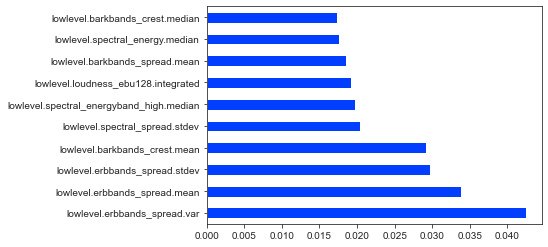

In [134]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X, y)

# plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.show()

## Correlation Matrix
Correlations state how the features are related to each other or the target variable. A heatmap makes it easy to identify which features are most related to the target variable.

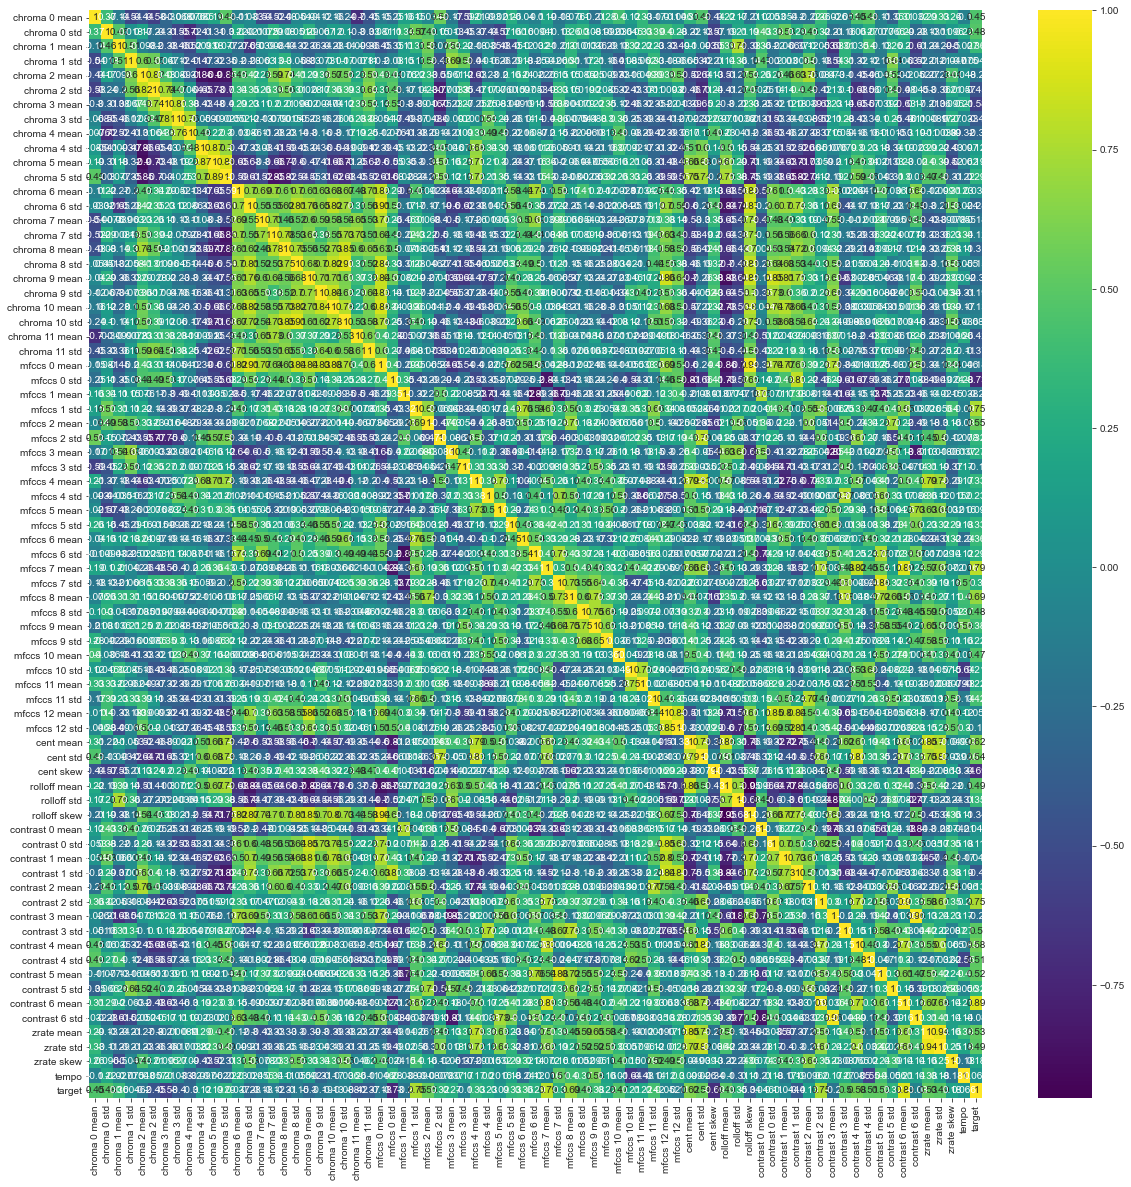

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns

# get correlations of each feature
correlation_matrix = df_audio.corr()
top_correlated_features = correlation_matrix.index
plt.figure(figsize=(20,20))

# plot heat map
g = sns.heatmap(df_audio[top_correlated_features].corr(), annot=True, cmap='viridis')

## Pearson Correlation
A filter-based feature selection method in which we check the absolute value of the Pearson's correlation between the target and numerical features in our dataset. We keep the top n features based on this criterion. 

In [135]:
num_feats = 10 # number of features to select
pearson_corrs = []
feature_names = X.columns.tolist()

# calculate the correlation of each feature with target
for f in feature_names:
    pearson_corr = np.corrcoef(X[f], y)[0, 1]
    pearson_corrs.append(pearson_corr)

# replace NaN with 0
pearson_corrs = [0 if np.isnan(i) else i for i in pearson_corrs]

# feature name
selected_features = X.iloc[:,np.argsort(np.abs(pearson_corrs))[-num_feats:]].columns.tolist()

# feature support
cor_support = [True if i in selected_features else False for i in feature_names]

# feature selection
allFeatureScores = pd.DataFrame({'feature': X.columns, 'score': pearson_corrs})
featureScores = allFeatureScores.loc[allFeatureScores.feature.isin(selected_features)]

print(featureScores)

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


                                feature     score
4       lowlevel.barkbands_crest.median  0.683667
16   lowlevel.barkbands_kurtosis.median  0.676763
32             lowlevel.dissonance.kurt  0.749591
45   lowlevel.erbbands_flatness_db.kurt -0.665580
64        lowlevel.erbbands_spread.mean  0.752384
67       lowlevel.erbbands_spread.stdev  0.831138
68         lowlevel.erbbands_spread.var  0.828760
112      lowlevel.melbands_skewness.var  0.675368
231      lowlevel.spectral_spread.stdev  0.681449
232        lowlevel.spectral_spread.var  0.785860


## Recursive Feature Elimination
This wrapper based method considers the selection of a set of features as a search problem.From the `sklearn` documention: "The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a `coef_` attribute or through a `feature_importances_` attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached."

We could use any estimator with this method. In this example, we use `LogisticRegression` where the RFE method observes the `coef_` attribute of the `LogisticRegression` object.

In [136]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

featureScores = pd.DataFrame({'feature': rfe_feature, 'score': rfe_selector.estimator_.coef_[0]})
print(featureScores)

Fitting estimator with 303 features.
Fitting estimator with 293 features.
Fitting estimator with 283 features.
Fitting estimator with 273 features.
Fitting estimator with 263 features.
Fitting estimator with 253 features.
Fitting estimator with 243 features.
Fitting estimator with 233 features.
Fitting estimator with 223 features.
Fitting estimator with 213 features.
Fitting estimator with 203 features.
Fitting estimator with 193 features.
Fitting estimator with 183 features.
Fitting estimator with 173 features.
Fitting estimator with 163 features.
Fitting estimator with 153 features.
Fitting estimator with 143 features.
Fitting estimator with 133 features.
Fitting estimator with 123 features.
Fitting estimator with 113 features.
Fitting estimator with 103 features.
Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting

## LASSO
This is an embedded method that uses algorithms that have built-in feature selection methods (e.g., Lasso's L1 norm as regularizer). The Lasso norm regularizer, unlike [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), forces a feature weights to zero. See penalty and solver options: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [137]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

lr_selector = SelectFromModel(estimator=LogisticRegression(penalty='l2', solver='newton-cg'), max_features=10)
lr_selector.fit(X, y)
lr_support = lr_selector.get_support()
lr_feature = X.loc[:,lr_support].columns.tolist()

allFeatureScores = pd.DataFrame({'feature': X.columns, 'score': lr_selector.estimator_.coef_[0]})
featureScores = allFeatureScores.loc[allFeatureScores.feature.isin(lr_feature)]

print(featureScores)

/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

                                            feature         score
19                  lowlevel.barkbands_kurtosis.var -2.445895e-08
148                  lowlevel.spectral_centroid.var -8.957588e-07
208                  lowlevel.spectral_kurtosis.var -2.276710e-08
220                   lowlevel.spectral_rolloff.var -2.993540e-08
228                   lowlevel.spectral_spread.mean -1.106547e-06
229                 lowlevel.spectral_spread.median -1.988794e-08
231                  lowlevel.spectral_spread.stdev -1.406629e-06
247  metadata.audio_properties.analysis.sample_rate -2.847734e-08
249              metadata.audio_properties.bit_rate -6.789441e-07
254           metadata.audio_properties.sample_rate -2.847734e-08


/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

## RandomForest Feature Selection
An embedded method that calculates feature importance using node impurities (average of all decision tree feature importances) in each decision tree.

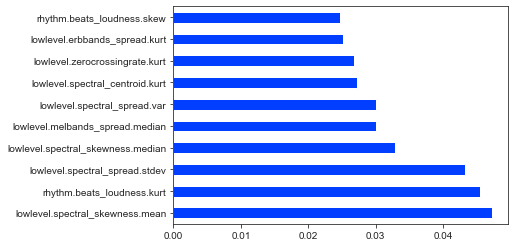

In [138]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=10)
rf_selector.fit(X, y)
rf_support = rf_selector.get_support()
rf_feature = X.loc[:,rf_support].columns.tolist()
#print(rf_feature)

model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)
#print(model.feature_importances_)

# plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.show()

## LightGBM Feature Selection
We could also have used a LightGBM or XGBoost or any tree-based classifier with the `feature_importances_` attribute.

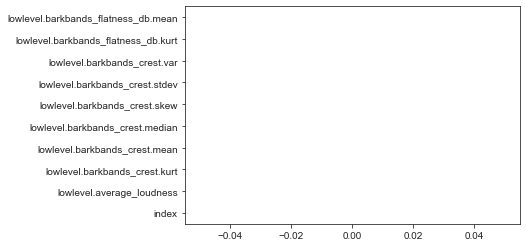

In [139]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

# hm... why is everything 0?

lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
lgbc.fit(X, y)

lgb_selector = SelectFromModel(lgbc, max_features=10)
lgb_selector.fit(X, y)
lgb_support = lgb_selector.get_support()
lgb_feature = X.loc[:,lgb_support].columns.tolist()

importances = pd.Series(lgbc.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')

## Feature Selection: All of 'em
Because why use just one, when we can have them all? (other than time and space constraints of course)

In [140]:
num_feats = 10
# put all selection together
feature_selection_df = pd.DataFrame(
    {'Feature': X.columns, 
     'Pearson': cor_support, 
     'Chi-2': chi_support, 
     'RFE': rfe_support, 
     'Logistics': lr_support,
     'Random Forest': rf_support, 
     'LightGBM': lgb_support
    })

# count the selected times for each feature
feature_selection_df['Count'] = np.sum(feature_selection_df, axis=1)

# display
feature_selection_df = feature_selection_df.sort_values(['Count', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df) + 1)
feature_selection_df.head(10)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Count
1,lowlevel.spectral_spread.stdev,True,False,True,True,True,False,4
2,lowlevel.spectral_spread.var,True,False,True,False,True,False,3
3,lowlevel.barkbands_crest.median,True,False,False,False,True,True,3
4,rhythm.beats_loudness.kurt,False,True,False,False,True,False,2
5,metadata.audio_properties.sample_rate,False,False,True,True,False,False,2
6,metadata.audio_properties.bit_rate,False,False,True,True,False,False,2
7,metadata.audio_properties.analysis.sample_rate,False,False,True,True,False,False,2
8,lowlevel.spectral_spread.median,False,False,True,True,False,False,2
9,lowlevel.spectral_spread.mean,False,False,True,True,False,False,2
10,lowlevel.spectral_rolloff.var,False,False,True,True,False,False,2
